### Imports

In [86]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from datetime import date

from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

import sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

### Functions

The system is defined by $\mathbf{x}=(b_0, b_A, a_0, m, r)$ and

\begin{align}
\dot{\mathbf{x}} &= \mathbf{A}(\mathbf{x}) + \frac{1}{\sqrt{N}}\boldsymbol \eta\\
\left\langle \eta_i(t) \eta_j(t')\right\rangle &= B_{ij}(\mathbf{x})\delta(t-t')
\end{align}

The functions $A_i$ are given by
\begin{align*}
\dot{b}_0 &= C_{br}(b_0+b_A)r + \alpha_b r - C_{ba}(b_A + a_0)b_0 - \alpha_a b_0 - (C_m m + \alpha_m)b_0-m_bb_0 + m_ab_A\\
\dot{b}_a &= C_{ba}(b_A + a_0)b_0 + \alpha_a b_0 - (C_m m + \alpha_m)b_A-m_ab_A - m_bb_A\\
\dot{a}_0 &= C_{ar}(b_A + a_0)r + \alpha_a r - (C_m m + \alpha_m)a_0-m_aa_0 + m_bb_A\\
\dot{m} &= (C_m m + \alpha_m)(b_0+b_A+a_0)-m_m m\\
\dot{r} &= -C_{br}(b_0+b_A)r - \alpha_b r - C_{ar}(b_A + a_0)r - \alpha_a r + m_bb_0 + m_aa_0 + m_m m
\end{align*}

And the correlator is
\begin{align*}
B_{b_0 b_0} &= C_{br}(b_0+b_A)r + \alpha_b r + C_{ba}(b_A + a_0)b_0 + \alpha_a b_0 + (C_m m + \alpha_m)b_0 + m_bb_0 + m_ab_A\\
B_{b_0 b_A} &= -C_{ba}(b_A + a_0)b_0 - \alpha_a b_0 -m_ab_A\\
B_{b_0 a_0} &= 0\\
B_{b_0 m} &= - (C_m m + \alpha_m)b_0\\
B_{b_0 r} &= -C_{br}(b_0+b_A)r - \alpha_b r - m_bb_0\\
B_{b_Ab_A} &= C_{ba}(b_A + a_0)b_0 + \alpha_a b_0 + (C_m m + \alpha_m)b_A+m_ab_A + m_bb_A\\
B_{b_Aa_0} &= - m_bb_A\\
B_{b_Am} &= - (C_m m + \alpha_m)b_A\\
B_{b_Ar} &= 0\\
B_{a_0a_0} &= C_{ar}(b_A + a_0)r + \alpha_a r + (C_m m + \alpha_m)a_0+m_aa_0 + m_bb_A\\
B_{a_0m} &= -(C_m m + \alpha_m)a_0\\
B_{a_0r} &= -C_{ar}(b_A + a_0)r - \alpha_a r - m_aa_0\\
B_{mm} &= (C_m m + \alpha_m)(b_0+b_A+a_0)+m_m m\\
B_{mr} &= -m_m m\\
B_{rr} &= C_{br}(b_0+b_A)r + \alpha_b r + C_{ar}(b_A + a_0)r + \alpha_a r + m_bb_0 + m_aa_0 + m_m m
\end{align*}

Below, $\mathbf{A}$, $\mathbf{B}$ and the Jacobian are given.

In [176]:
ndim = 5

def A(x, t, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, strength, N = params
    b0, ba, a0, m, r = np.maximum(x, np.zeros(ndim))
    return np.array([Cbr*(b0 + ba)*r + ib*r - Cab*(ba + a0)*b0 - ia*b0 - (Cm*m + im)*b0 - mb*b0 + force(t, strength)*ma*ba,
                     Cab*(ba + a0)*b0 + ia*b0 - (Cm*m + im)*ba - force(t, strength)*ma*ba - mb*ba,
                     Car*(ba + a0)*r + ia*r - (Cm*m + im)*a0 - force(t, strength)*ma*a0 + mb*ba,
                     (Cm*m + im)*(b0 + a0 + ba) - force(t, strength)*mm*m,
                     -Cbr*(b0 + ba)*r - ib*r - Car*(ba + a0)*r - ia*r + mb*b0 + force(t, strength)*ma*a0 + force(t, strength)*mm*m])

def B(x, t, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, strength, N = params
    b0, ba, a0, m, r = np.maximum(x, np.zeros(ndim))
    return np.array([[Cbr*(b0 + ba)*r + ib*r + Cab*(ba + a0)*b0 + ia*b0 + (Cm*m + im)*b0 + mb*b0 + force(t, strength)*ma*ba,
                      -Cab*(ba + a0)*b0 - ia*b0 - force(t, strength)*ma*ba, 0, -(Cm*m + im)*b0, -Cbr*(b0 + ba)*r - ib*r - mb*b0],
                     [-Cab*(ba + a0)*b0 - ia*b0 - force(t, strength)*ma*ba,
                      Cab*(ba + a0)*b0 + ia*b0 + (Cm*m + im)*ba + force(t, strength)*ma*ba + mb*ba, -mb*ba, -(Cm*m + im)*ba, 0],
                     [0, -mb*ba, Car*(ba + a0)*r + ia*r + (Cm*m + im)*a0 + force(t, strength)*ma*a0 + mb*ba, -(Cm*m + im)*a0,
                      -Car*(ba + a0)*r - ia*r - force(t, strength)*ma*a0],
                     [-(Cm*m + im)*b0, -(Cm*m + im)*ba, -(Cm*m + im)*a0, (Cm*m + im)*(b0 + a0 + ba) + force(t, strength)*mm*m,
                      -force(t, strength)*mm*m],
                     [-Cbr*(b0 + ba)*r - ib*r - mb*b0, 0, -Car*(ba + a0)*r - ia*r - force(t, strength)*ma*a0,
                      -force(t, strength)*mm*m,
                      Cbr*(b0 + ba)*r + ib*r + Car*(b0 + a0)*r + ia*r + mb*b0 + force(t, strength)*ma*a0 + force(t, strength)*mm*m]
                      ])

def Jac(x, t, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, strength, N = params
    y = np.maximum(x[:ndim], np.zeros(ndim))
    b0, ba, a0, m, r = y
    return np.array([[Cbr*r - Cab*(ba + a0) - ia - (Cm*m + im) - mb, Cbr*r - Cab*b0 + force(t, strength)*ma, - Cab*b0, - Cm*b0,
                  Cbr*(b0 + ba) + ib], [Cab*(ba + a0) + ia, Cab*b0 - (Cm*m + im) - force(t, strength)*ma - mb, Cab*b0, - Cm*ba, 0.],
                 [0., Car*r + mb, Car*r - (Cm*m + im) - force(t, strength)*ma, - Cm*a0, Car*(ba + a0) + ia],
                 [(Cm*m + im), (Cm*m + im), (Cm*m + im), Cm*(b0 + a0 + ba) - force(t, strength)*mm, 0.],
                 [-Cbr*r + mb, -Cbr*r - Car*r, -Car*r + force(t, strength)*ma, force(t, strength)*mm, -Cbr*(b0 + ba) - ib - Car*(ba + a0) - ia]])

The function below returns a realisation of the SDEs

In [177]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    N = params[-1]
    
    x_t = []
    
    x_0 = x.copy()
    for time in t:
        x_t.append(x_0.copy())
        y = A(x_0, time, *params)*dt + np.sqrt(dt/N)*np.random.multivariate_normal(np.zeros(ndim), B(x_0, time, *params))
        x_0 += y
        
    x_t = np.array(x_t)
            
    return np.maximum(x_t, 0.)

### Deterministic dynamics with the parameters from the PNAS paper

In [181]:
Cbr = 0.018
Cab = 0.049
Cm = 0.078
Car = 0.021
mb = 0.003
ma = 0.013
mm = 0.017
ib = 0.0000001
ia = 0.0000001
im = 0.0000001
strength = 0.28
N = np.inf

params = (Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, strength, N)

x0 = [0.1, 0.01, 0.05, 0.05, 0.79]

In [182]:
dt = 0.1

t_full = np.arange(0., 365*25., dt)
x_real = path(x0, t_full, *params)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

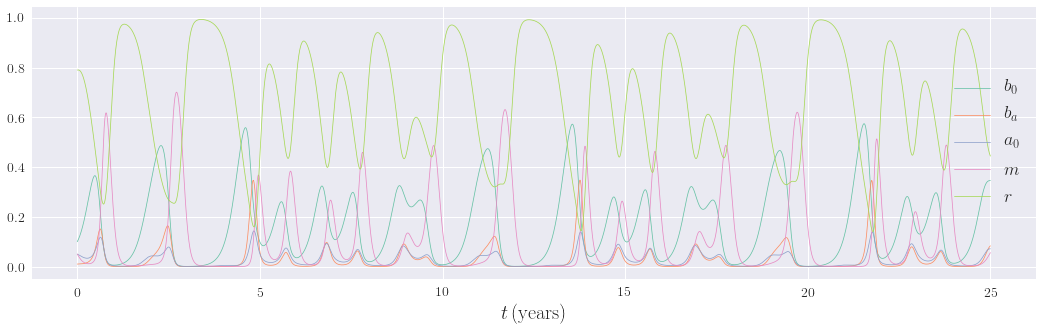

In [183]:
fig, ax = plt.subplots(1, figsize=(18,5))
labels = [r'$b_0$', r'$b_a$', r'$a_0$', r'$m$', r'$r$']
for i in range(5):
    ax.plot(t_full/365., x_real[:,i], linewidth=0.75, label=labels[i])
ax.set_xlabel(r'$t\, \mathrm{(years)}$', fontsize=20)
ax.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Importing and cleaning the data

We use the interpolated dataset.

In [184]:
data = pd.read_csv('./interpolated_data.csv', parse_dates=[0], dayfirst=True)
data = data.rename(columns={"'Date'": 'date', "'Barnacles [%]'": 'B', "'Crustose algae [%]'": 'A', "'Mussels [%] '": 'M',
                            "'Bare rock [%]'": 'R'})

In [185]:
data.head()

,date,B,A,M,R
0,1987-10-22,92.81,53.23,0.00,7.19
1,1987-11-21,91.09,53.73,3.23,8.91
2,1987-12-21,94.57,59.16,5.78,5.43
3,1988-01-20,95.20,63.96,7.62,4.80
4,1988-02-19,95.57,68.33,8.70,4.43


#### Normalisation problems

The relationship between the data and the model is given by

$$\begin{align}
B &= (b_0 + b_A)\, \times 100\%\\
A &= (a_0 + b_A)\, \times 100\%\\
M &= m\, \times 100\%\\
B &= r\, \times 100\%
\end{align}$$

Thus, every data point should satisfy $B+A+M+R = 100(1+b_A)$. For a data point to be correctly normalised, we should have
1. $B + A + M + R \geq 100$
2. $\max (B,A) + M + R \leq 100$

Number of data points violating the first condition

In [186]:
data_lack = data[data.B+data.A+data.M+data.R<100]
data_lack['sum'] = data_lack[['B', 'A', 'M', 'R']].sum(axis=1)
n_lack = data_lack.shape[0]
n_lack

33

Number of data points violating the second condition

In [187]:
data2 = data.copy()
data2['maxBA'] = data2[['B', 'A']].max(axis=1)
data2['sum'] = data2[['maxBA', 'M', 'R']].sum(axis=1)

In [188]:
data_excess = data2[data2['sum']>100]
n_excess = data_excess.shape[0]
n_excess

125

Total number of incorrectly normalised data points

In [189]:
n_lack + n_excess

158

Total number of entries

In [190]:
data.shape[0]

251

More than half of the data points are incorrectly normalised. Let's look at some (the last 10) of the values when the sum of all variables is less than 100%:

In [191]:
data_lack.tail(10)

,date,B,A,M,R,sum
63,1992-12-24,33.58,0.00,1.46,38.89,73.93
64,1993-01-23,43.32,0.00,4.18,21.37,68.87
65,1993-02-22,46.70,0.00,5.31,17.08,69.09
66,1993-03-24,51.02,0.00,7.33,16.48,74.83
67,1993-04-23,56.72,0.00,10.06,17.24,84.02
68,1993-05-23,54.16,1.07,14.99,17.08,87.30
69,1993-06-22,43.37,5.57,22.29,16.25,87.48
70,1993-07-22,36.39,11.41,31.72,15.89,95.41
90,1995-03-14,6.05,0.00,10.07,82.77,98.89
100,1996-01-08,77.81,1.13,0.00,20.58,99.52


The situation is not so bad here. The last data point with this problem comes just after the change in the way of sampling (Dec 1995). It is almost 100% anyway and there are no errors of this type after Jan 1996. There are uglier ones but if we ignore the data before 1996 there is no problem. For the opposite case, focusing only on dates after Dec 1995 and showing the 10 of them with the largest values we get:

In [192]:
data_excess[data_excess.date>'1995-12-07'].sort_values(by='sum', ascending=False).head(10)

,date,B,A,M,R,maxBA,sum
186,2003-02-01,17.85,70.40,74.68,8.39,70.40,153.47
185,2003-01-02,34.62,74.97,60.60,4.87,74.97,140.44
187,2003-03-03,8.44,47.45,82.38,9.43,47.45,139.26
184,2002-12-03,53.60,74.62,41.57,4.91,74.62,121.10
216,2005-07-20,29.30,10.76,65.00,25.08,29.30,119.38
250,2008-05-05,53.69,69.48,41.00,5.43,69.48,115.91
215,2005-06-20,29.75,11.42,61.81,19.66,29.75,111.22
188,2003-04-02,12.23,17.53,79.41,8.57,17.53,105.51
214,2005-05-21,29.57,12.07,56.71,17.71,29.57,103.99
218,2005-09-18,26.24,9.38,37.55,40.02,26.24,103.81


In [193]:
threshold = 105.
dates_drop = data_excess[(data_excess.date>'1995-12-07') & (data_excess['sum']>threshold)].date.values

idx_drop = []
for x in dates_drop:
    idx_drop=idx_drop+data[data.date==x].index.values.tolist()

Here there are a few (very) ugly cases after Dec 1995, but most of the values are also very close to 100%. Since our parameter estimation only requires that we have information for the same variables at every time point, but not necessarily that the time points are equidistant, we could simply remove data points that surpass a certain threshold, say 105% (the points crossing this threshold are saved above).

#### Renormalising and assigning values to $b_0$, $a_0$ and $b_A$ from $B$ and $A$

1. For correctly normalised data we take $b_A = (B+A+M+R)/100 - 1$. Then $b_0 = B/100 - b_A$ and $a_0 = A/100 - b_A$.

2. For points violating the first condition, the "excess" over 100 is negative, which would result in $b_A < 0$. I truncate $b_A = 0$ and then fill the remaining space with rock by forcing $r = 1 - (B + A + M)/100$.
3. For points violating the second condition, there are two cases:
    - If $\max (B,A) + M > 100$, I set $r = 0$ and force $m = 1 - \max(B,A)/100$.
    - If not, I force $r = 1 - [\max (B,A) + M]/100$.  
After this, I assume that whichever population is smaller between $B$ and $A$ is fully concentrated in $b_A$; that is, if $B>A$ (resp. $A>B$), then $b_A = A/100$, $b_0 = (B - A)/100$ and $a_0 = 0$ (resp. $b_A = B/100$, $a_0 = (A - B)/100$ and $b_0 = 0$.

In [194]:
b0 = np.empty_like(data.B)
ba = np.empty_like(data.B)
a0 = np.empty_like(data.B)
m = np.empty_like(data.B)
r = np.empty_like(data.B)

for idx, row in data.reset_index().iterrows():
    maxBA = np.maximum(row['B'], row['A'])
    if maxBA + row['M'] + row['R'] > 100.:
        if row['A'] > row['B']:
            b0[idx] = 0.
            ba[idx] = row['B']
            a0[idx] = row['A'] - row['B']
        else:
            b0[idx] = row['B'] - row['A']
            ba[idx] = row['A']
            a0[idx] = 0.
        if maxBA + row['M'] > 100.:
            r[idx] = 0.
            m[idx] = 100. - maxBA
        else:
            m[idx] = row['M']
            r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
    elif row['B'] + row['A'] + row['M'] + row['R'] < 100.:
        b0[idx] = row['B']
        ba[idx] = 0.
        a0[idx] = row['A']
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
    else:
        ba[idx] = (row['B'] + row['A'] + row['M'] + row['R']) - 100.
        b0[idx] = row['B'] - ba[idx]
        a0[idx] = row['A'] - ba[idx]
        m[idx] = row['M']
        r[idx] = row['R']
        
data[r'$b_0$'] = np.maximum(b0/100.,0.)
data[r'$b_A$'] = np.maximum(ba/100.,0.)
data[r'$a_0$'] = np.maximum(a0/100.,0.)
data[r'$m$'] = np.maximum(m/100.,0.)
data[r'$r$'] = np.maximum(r/100.,0.)

#### Removing older and bad data points

We will not care about strong violations of the normalisation conditions, so we discard everything before Dec 1995 and also those weird data points in 2003, 2005 and 2008

In [195]:
data_clean = data.drop(idx_drop, axis=0).drop(['B', 'A', 'M', 'R'], axis=1)
data_clean = data_clean[data_clean.date > '1995-12-07'].reset_index().drop(['index'], axis=1)

In [196]:
date_init = data_clean.date[0]

data_clean['days'] = data_clean['date'] - date_init
data_clean['days'] = data_clean['days'].apply(lambda x: int(x.days))

In [197]:
data_clean = data_clean.drop(['date'], axis=1)
data_clean.index = data_clean.days
data_clean = data_clean.drop(['days'], axis=1)

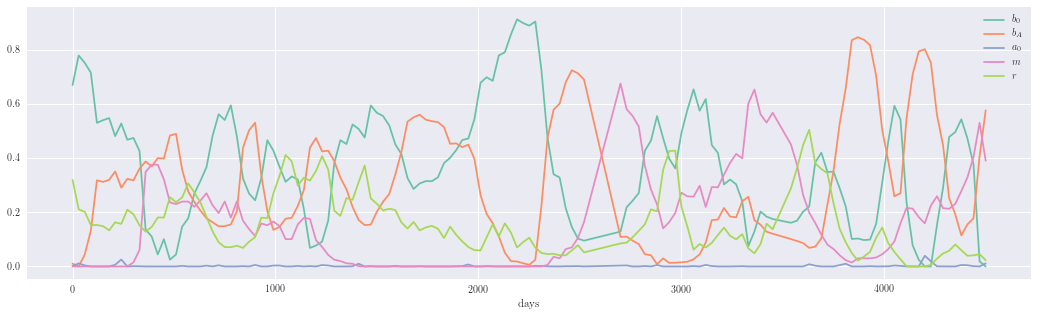

In [198]:
data_clean.plot(figsize=(18,5))

We define the forcing term $F(t)$ here&mdash;Eq. (6) from PNAS paper&mdash;that affects the mortality of mussels and algae so that $m_m$ becomes $F(t)m_m$ and $m_a$ becomes $F(t)m_a$, with
$$F(t) = 1 + \gamma(T_{max} - T_{mean})\cos \left(\frac{2\pi(t-54)}{365}\right)$$
where $T$ is the temperature and $\gamma$ the forcing strength.

Note that the maximum is at 54 days instead of 32, because the first date of the 'clean' dataset corresponds to 9 Dec.

In [199]:
Tmax= 20.5
Tmean = 17.1

def force(t, strength):
    return 1. + strength*(Tmax - Tmean)*np.cos(2*np.pi*(t-54)/365)

### The estimation itself

In [200]:
observations = (data_clean.values, data_clean.index.values)

zimmer = sdeparams.Zimmer(A, B, Jac, observations, ndim, timestep=25000)

In [216]:
bounds = [(0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.00001, 0.0005), (0.000001, 0.001), (0.00001, 0.01),
          (0.00001, 0.01), (0.0000001, 0.00001), (0., 0.), (0., 0.), (0.01, 1.), (100, 2000)]

estimation = differential_evolution(zimmer.costfn, bounds)

In [217]:
params_estim = tuple(estimation.x)

x_estim = np.maximum(zimmer.reconstruct(params_estim), 0.)

In [218]:
Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, strength, N = params_estim

In [201]:
bounds = [(0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.00001, 0.0005), (0.000001, 0.001), (0.00001, 0.01),
          (0.00001, 0.01), (0.0000001, 0.00001), (0., 0.), (0., 0.), (0.01, 0.01), (10, 2000)]


In [223]:
params_table = pd.DataFrame({r'$C_{br}$': Cbr, r'$C_{ab}$': Cab, r'$C_{m}$': Cm, r'$C_{ar}$': Car,
                             r'$m_{b}$': mb, r'$m_{a}$': ma, r'$m_{m}$': mm, r'$\alpha_{b}$': ib,
                             r'$\alpha_{a}$': ia, r'$\alpha_{m}$': im, r'$\gamma$': strength, r'$N$': N}, index=[0])

params_table

,$C_{br}$,$C_{ab}$,$C_{m}$,$C_{ar}$,$m_{b}$,$m_{a}$,$m_{m}$,$\alpha_{b}$,$\alpha_{a}$,$\alpha_{m}$,$\gamma$,$N$
0,0.014978,0.036493,0.015034,0.000281,0.000407,0.009718,0.005364,0.000002,0.0,0.0,0.010767,100.123951


#### Reconstructing the time series with the estimated parameters

In [224]:
init_cond = np.concatenate((observations[0][0], np.zeros(ndim**2)))
t_full = np.linspace(observations[1][0], observations[1][-1], 10000)

x_det = odeint(zimmer.LNA, init_cond, t_full, args=params_estim)[:, :ndim]

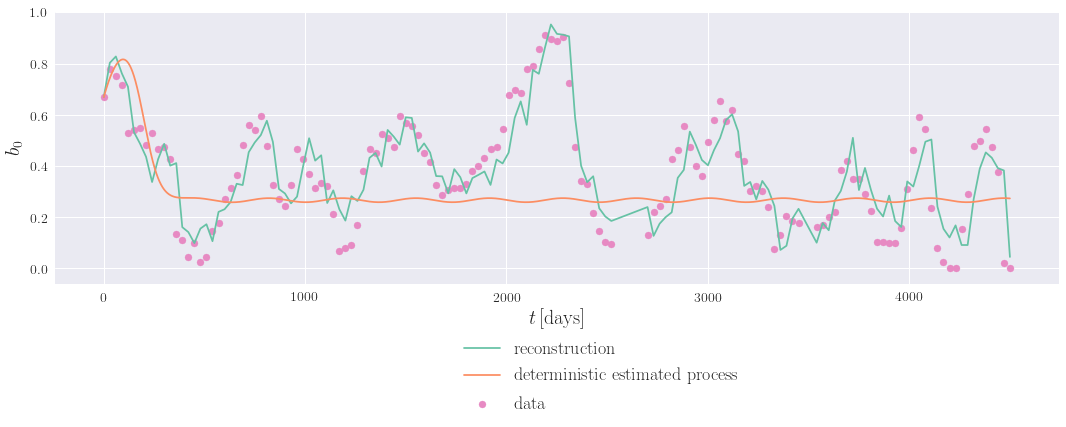

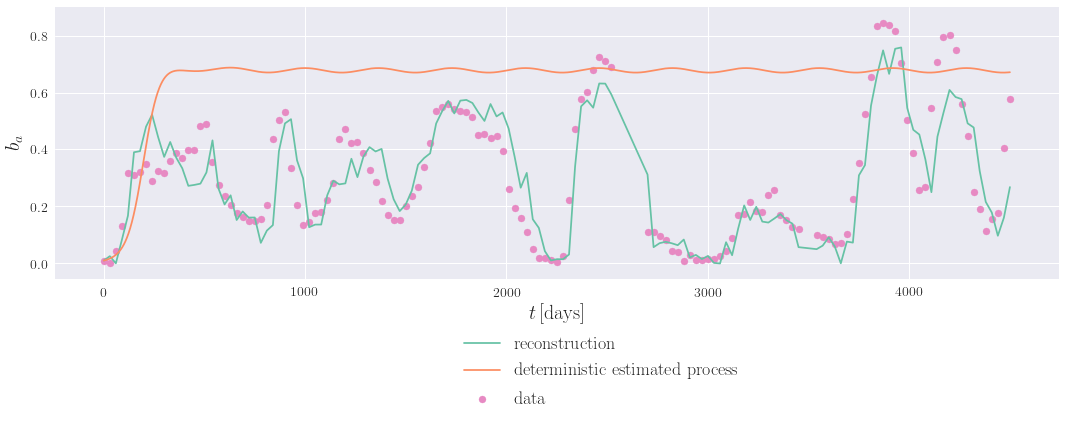

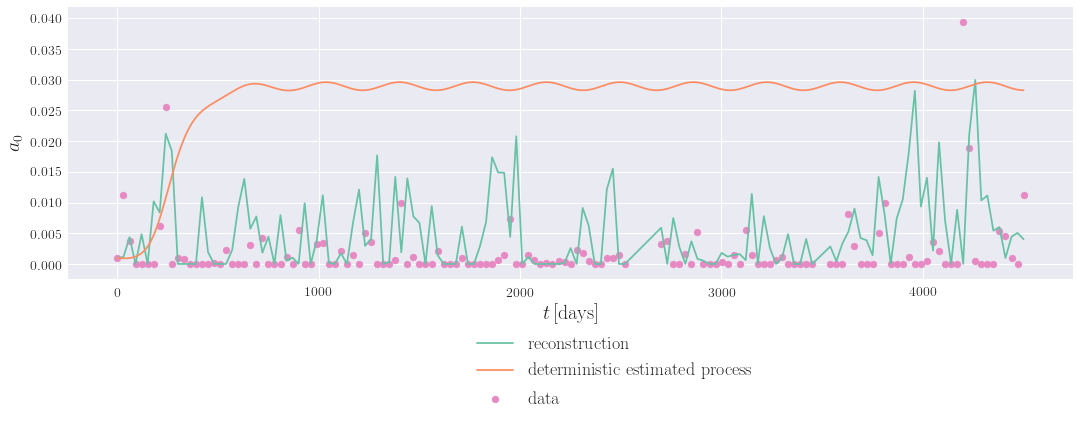

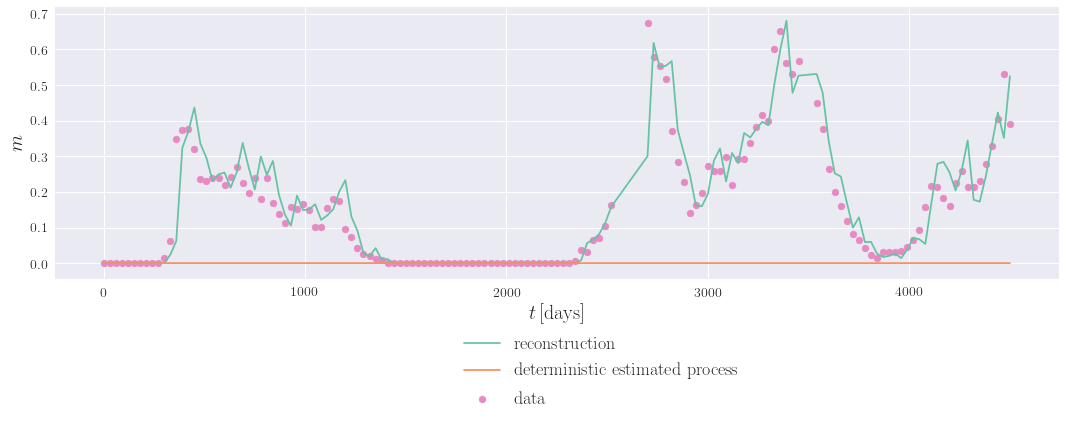

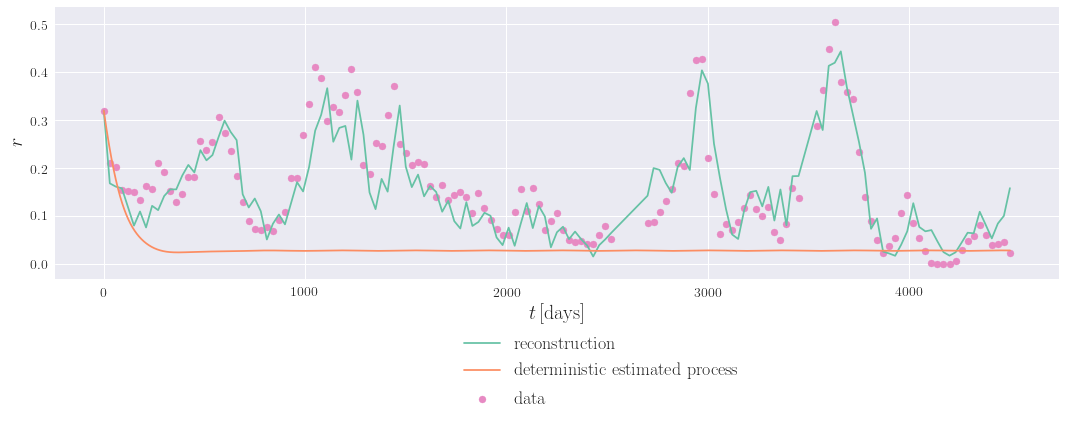

In [229]:
for i in range(ndim):
    fig, ax = plt.subplots(1, figsize=(18,5))
    ax.plot(observations[1], x_estim[:,i], label=r'reconstruction')
    ax.plot(t_full, x_det[:,i], label=r"deterministic estimated process")
    ax.scatter(observations[1], observations[0][:, i], color=colours[3], label="data")
    ax.set_xlabel(r'$t\, [\mathrm{days}]$', fontsize=20)
    ax.set_ylabel(labels[i], fontsize=20)
    ax.legend(fontsize=18, loc=(0.4,-0.5))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)